# 적대적 생성 신경망 GAN

## 1) generator

In [5]:
import keras
from keras import layers
import numpy as np

latent_dim = 32  # 랜덤 벡터 사이즈 (잠재 공간의 무작위한 포인트)

# 식별자 모델에 입력될 데이터의 shape
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))  # 생성자 네트워크에 shape=32의 데이터를 입력 

# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
x = layers.Dense(128 * 16 * 16)(generator_input)  # 128x16x16 의 크기로 출력
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)  # 출력된 결과물을 reshape

# 합성곱 층을 추가합니다
# 채널 개수=256, 커널 사이즈=5x5
# 입출력 이미지의 사이즈 동일
x = layers.Conv2D(256, 5, padding='same')(x)  
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
# 256개의 5x5 필터 설정
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 3개의 7x7 필터를 통과
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = keras.models.Model(generator_input, x)  # 생성자 네트워크 구성
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

## 2) 판별자

In [2]:
# 판별자 모델에 입력될 데이터의 shape=(32,32,3)
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 생성자가 생성한 노이즈 이미지를 해결하기 위해 드롭아웃 층을 넣는다.
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

# 식별자 네트워크 구성
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
# Gradient Clipping : 그래디언트 폭주를 막기 위해, 역전파 단계에서 기울기 값이 특정 임계치를 넘지 못하게 제한한다.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

## 3) 적대적 네트워크

In [3]:
# 판별자의 가중치가 훈련되지 않도록 설정합니다(gan 모델에만 적용됩니다)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))  # 랜덤 노이즈 = 32차원
gan_output = discriminator(generator(gan_input))

# GAN 함수 정의
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## 4) DCGAN 훈련




In [ ]:
import os
from keras.preprocessing import image

# CIFAR10 데이터를 로드합니다
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터를 정규화합니다
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
#save_dir = '/content/sample_data'
#if not os.path.exists(save_dir):
#    os.mkdir(save_dir)

# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        #img = image.array_to_img(generated_images[0] * 255., scale=False)
        #img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        #img = image.array_to_img(real_images[0] * 255., scale=False)
        #img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

스텝 0에서 판별자 손실: 0.7452754378318787
스텝 0에서 적대적 손실: 0.7883732318878174
스텝 100에서 판별자 손실: 0.6927130222320557
스텝 100에서 적대적 손실: 0.7432834506034851
스텝 200에서 판별자 손실: 0.7000331878662109
스텝 200에서 적대적 손실: 0.7692786455154419
스텝 300에서 판별자 손실: 0.7160402536392212
스텝 300에서 적대적 손실: 1.3634451627731323
스텝 400에서 판별자 손실: 0.6777041554450989
스텝 400에서 적대적 손실: 0.7752559781074524
스텝 500에서 판별자 손실: 0.687684953212738
스텝 500에서 적대적 손실: 0.7976940274238586


## 5) 가짜 이미지 출력

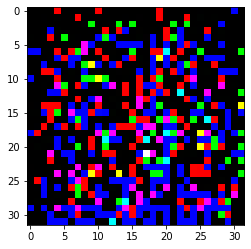

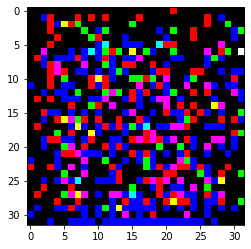

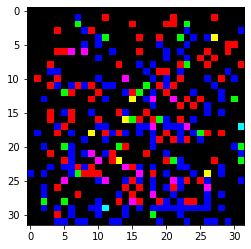

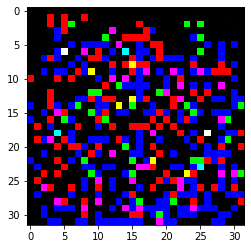

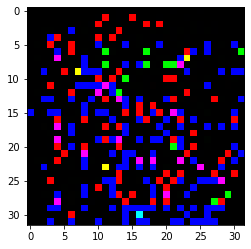

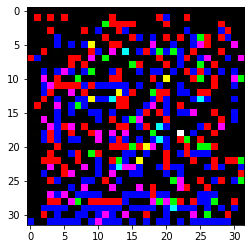

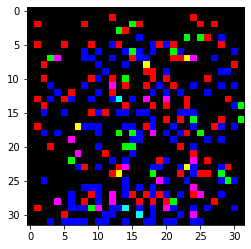

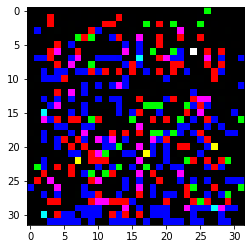

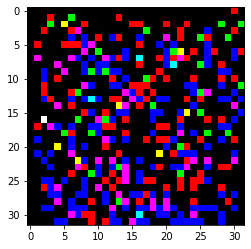

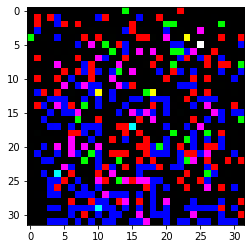

In [7]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

# 잠재 공간에서 랜덤한 포인트를 샘플링합니다
latent_dim = 32  # 랜덤 벡터 사이즈 (잠재 공간의 무작위한 포인트)
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩합니다
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

적은 수의 스텝을 사용했기 때문에 덜 자세한 이미지가 표현된다.